In this part we will cluster the documents, visualise the clusters and to try to understand what types of groups are
present.


## Data preparation


### Data loading

First thing we need to do is load the set of document.

In [1]:
from datasets import load_dataset

dataset = load_dataset('derek-thomas/ScienceQA')
#print(len(dataset['train']))


Let's check the size of the data set:

In [2]:
print(f"No. of documents: {len(dataset['train'])}")
print(f"No. of documents: {len(dataset['validation'])}")
print(f"No. of documents: {len(dataset['test'])}")


No. of documents: 12726
No. of documents: 4241
No. of documents: 4241


In [3]:
for key, value in dataset['train'][1].items():
    print(f"{key}: {value}")

image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=302x232 at 0x198FC2C3410>
question: Identify the question that Tom and Justin's experiment can best answer.
choices: ['Do ping pong balls stop rolling along the ground sooner after being launched from a 30° angle or a 45° angle?', 'Do ping pong balls travel farther when launched from a 30° angle compared to a 45° angle?']
answer: 1
hint: The passage below describes an experiment. Read the passage and then follow the instructions below.

Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° angle. With each launch, his friend Justin measured the distance between the catapult and the place where the ball hit the ground. Tom and Justin repeated the launches with ping pong balls in four more identical catapults. They compared the distances the balls traveled when launched from a 4

In [4]:
print(f"Label for the first example is: {dataset['train'][0]['category']}")
print('\nCategories:')
{sample['category'] for sample in dataset['train']}

Label for the first example is: Geography

Categories:


{'20th century American history',
 'Adaptations',
 'Adaptations and natural selection',
 'Age of Exploration',
 'Analyzing literature',
 'Ancient Mesopotamia',
 'Ancient South Asia',
 'Animals',
 'Asia: society and environment',
 'Astronomy',
 'Atoms and molecules',
 'Audience, purpose, and tone',
 "Author's purpose",
 "Author's purpose and tone",
 'Basic economic principles',
 'Biochemistry',
 'Capitalization',
 'Categories',
 'Cells',
 'Chemical reactions',
 'Cities',
 'Classification',
 'Classification and scientific names',
 'Climate change',
 'Colonial America',
 'Comprehension strategies',
 'Conservation',
 'Conservation and natural resources',
 'Context clues',
 'Creative techniques',
 'Cultural celebrations',
 'Descriptive details',
 'Designing experiments',
 'Developing and supporting arguments',
 'Domain-specific vocabulary',
 'Early 19th century American history',
 'Early Americas',
 'Early China',
 'Early Modern Europe',
 'Earth events',
 "Earth's features",
 'Ecological in

### Data preprocessing

Before moving to clustering and topic modelling we need to preprocess our data set to extract the documents and the labels inside.

We are going to create our collection of documents combining the "question", "hint", "lecture" and the "solution" of a sample in our data set.

In [5]:
documents = [f"{sample['question']}\n\n{sample.get('hint', '')}\n\n{sample.get('lecture', '')}\n\n{sample.get('solution', '')}" 
             for sample in dataset['train']]

Let's give a look at the labels distribution.
We need to retain the associated labels for the future assessment of the clustering result.
We count the occurrences of each label using Python's `Counter`

In [6]:
labels = [sample['category'] for sample in dataset['train']]
from collections import Counter

label_count = Counter(labels)
label_count

Counter({'State capitals': 845,
         'Literary devices': 739,
         'Genes to traits': 553,
         'Classification': 497,
         'Materials': 489,
         'Units and measurement': 470,
         'Reference skills': 419,
         'Sentences, fragments, and run-ons': 409,
         'Designing experiments': 393,
         'Magnets': 374,
         'Adaptations': 313,
         'Weather and climate': 298,
         'Basic economic principles': 291,
         'Developing and supporting arguments': 257,
         'Formatting': 252,
         'Velocity, acceleration, and forces': 252,
         'Ecosystems': 227,
         'Solutions': 222,
         'Traits and heredity': 220,
         'Force and motion': 207,
         'Geography': 200,
         'Physical and chemical change': 192,
         'Maps': 190,
         'Oceania: geography': 176,
         'Engineering practices': 174,
         'Classification and scientific names': 173,
         'Rocks and minerals': 170,
         'Particle motion a

Now we can visualise the counts of each label

In [7]:
label_count.keys()

dict_keys(['Geography', 'Designing experiments', 'Verb tense', 'Physical and chemical change', 'Pronouns', 'Genes to traits', 'Particle motion and energy', 'Ecological interactions', 'Solutions', 'Magnets', 'Units and measurement', 'Plants', 'Editing and revising', 'Traits and heredity', 'Materials', 'State capitals', 'Heredity', 'States of matter', 'Literary devices', 'Classification', 'Atoms and molecules', 'Basic economic principles', 'Animals', 'Heat and thermal energy', 'Reference skills', 'Adaptations', 'Rhyming', 'Sentences, fragments, and run-ons', 'Supply and demand', 'Opinion writing', 'Weather and climate', 'Formatting', 'Velocity, acceleration, and forces', 'Developing and supporting arguments', 'Chemical reactions', 'Plant reproduction', 'Kinetic and potential energy', 'Capitalization', 'Ecosystems', 'Word usage and nuance', 'Force and motion', "Author's purpose and tone", 'The Americas: geography', 'Colonial America', 'Engineering practices', 'Thermal energy', 'Creative t

c:\Users\guill\miniconda3\envs\env17\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


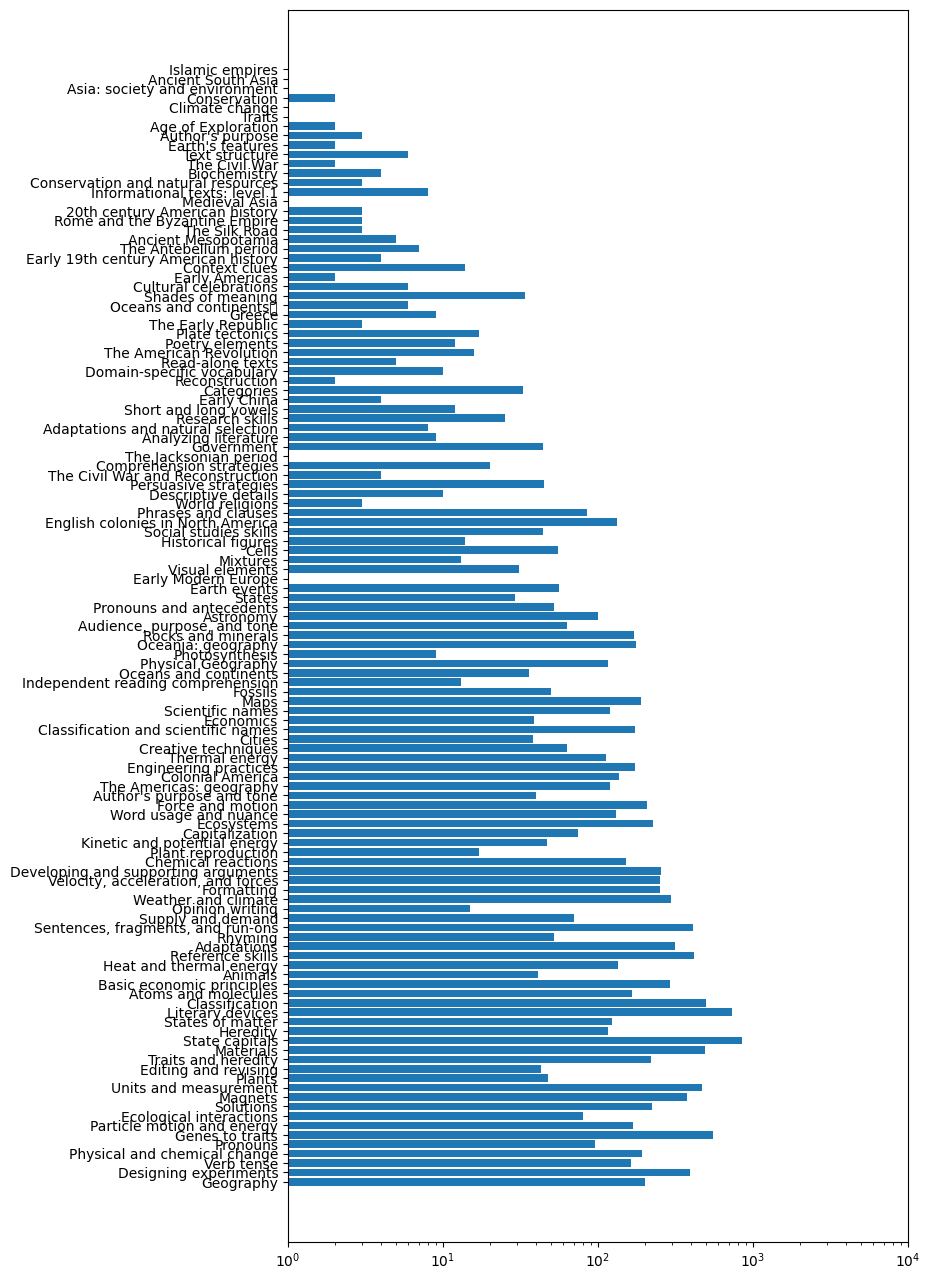

In [8]:
from matplotlib import pyplot as plt


plt.figure(figsize=(8, 16))
plt.barh(range(len(label_count)), label_count.values())
plt.yticks(range(len(label_count)), label_count.keys())
plt.xscale('log')
plt.xlim([1, 10000])
plt.show()

Some labels are way more frequent than the others, note that we are using a logarithmic scale on the x-axis.
There are even some labels that are present only once.

### Documents vectorisation

In order to cluster the documents, we need to first convert them into a vector format. We will use the `TfidfVectorizer` from Scikit-Learn to do this.

The vectorisation method takes a number of arguments that control the resulting vocabulary. We have set the following arguments:  
- **max_df = 0.8**: remove words occuring in 80 percent of the documents (note: this will get rid of any corpus-specific tags)
- **min_df = 5**: remove words occuring in less than 5 documents  
- **stop_words = 'english'**: remove stopwords using an english stopword list

We can now fit the vectorizer to the data:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [10]:
vectorizer.fit(documents)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

Let's have a quick look at the vocabulary :

In [11]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 5911


Let's print out a random sample of 100 terms from it to see what they look like:

In [12]:
import random

sorted(random.sample(vocab.tolist(),100))

['16',
 '170',
 '176',
 '215',
 '250',
 '34',
 '43',
 '55',
 'alligator',
 'answers',
 'ant',
 'assistant',
 'assonance',
 'barbuda',
 'beaches',
 'beryllium',
 'billion',
 'bite',
 'brendan',
 'canada',
 'carol',
 'cart',
 'cereal',
 'characteristics',
 'claim',
 'claiming',
 'cole',
 'compares',
 'condensing',
 'conversational',
 'convince',
 'cough',
 'cow',
 'crustacean',
 'cuts',
 'death',
 'domestic',
 'drying',
 'educational',
 'electric',
 'erin',
 'faced',
 'flexible',
 'flightless',
 'following',
 'foods',
 'fries',
 'grasshopper',
 'grown',
 'habitats',
 'high',
 'hiked',
 'hot',
 'idioms',
 'investigate',
 'irma',
 'iron',
 'jeanette',
 'josie',
 'lamp',
 'laughter',
 'layout',
 'lead',
 'leroy',
 'lettuce',
 'lower',
 'lowest',
 'maritimus',
 'melt',
 'meterstick',
 'moon',
 'movement',
 'mug',
 'nebraska',
 'observable',
 'pairs',
 'penny',
 'position',
 'predator',
 'printing',
 'rat',
 'reggie',
 'relationship',
 'repeated',
 'replacing',
 'shape',
 'ships',
 'shoebox',

Now let's vectorize the dataset:

In [13]:
vector_documents = vectorizer.transform(documents)

Here is the sparse vector for the first document:

In [14]:
print(vector_documents[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 28 stored elements and shape (1, 5911)>
  Coords	Values
  (0, 308)	0.056263121471177104
  (0, 379)	0.18577414550299118
  (0, 380)	0.09322903006029049
  (0, 880)	0.2980566061289045
  (0, 1195)	0.2992327107774365
  (0, 1590)	0.07825436758901869
  (0, 1591)	0.3798721450619788
  (0, 1737)	0.09405001674961348
  (0, 2004)	0.19585555309829586
  (0, 3085)	0.07456321947083243
  (0, 3175)	0.09292260305044148
  (0, 3243)	0.08965407028585859
  (0, 3269)	0.09034050583150526
  (0, 3271)	0.1856612689760632
  (0, 3626)	0.559212528977412
  (0, 4013)	0.08357316279131098
  (0, 4014)	0.09369410130173758
  (0, 4015)	0.09243989033447884
  (0, 4020)	0.08540535138666881
  (0, 4519)	0.29510074646022866
  (0, 4709)	0.09054096046707581
  (0, 4789)	0.05460441591087873
  (0, 4964)	0.08043170843485696
  (0, 5060)	0.08089660255836084
  (0, 5626)	0.06509548171627283
  (0, 5691)	0.12042545027969728
  (0, 5769)	0.06479490248970839
  (0, 5797)	0.1849905071641

The decimial values are the TF-IDF scores for the terms. We can sort the terms by their TF-IDF values, and print them out as follows:

In [15]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('north', np.float64(0.559212528977412)),
 ('directions', np.float64(0.3798721450619788)),
 ('compass', np.float64(0.2992327107774365)),
 ('cardinal', np.float64(0.2980566061289045)),
 ('rose', np.float64(0.29510074646022866)),
 ('farthest', np.float64(0.19585555309829586)),
 ('arrow', np.float64(0.18577414550299118)),
 ('maps', np.float64(0.1856612689760632)),
 ('west', np.float64(0.1849905071641223)),
 ('virginia', np.float64(0.12042545027969728)),
 ('east', np.float64(0.09405001674961348)),
 ('pointing', np.float64(0.09369410130173758)),
 ('arrows', np.float64(0.09322903006029049)),
 ('look', np.float64(0.09292260305044148)),
 ('points', np.float64(0.09243989033447884)),
 ('set', np.float64(0.09054096046707581)),
 ('map', np.float64(0.09034050583150526)),
 ('main', np.float64(0.08965407028585859)),
 ('pole', np.float64(0.08540535138666881)),
 ('point', np.float64(0.08357316279131098)),
 ('states', np.float64(0.08089660255836084)),
 ('south', np.float64(0.08043170843485696)),
 ('dir

In [16]:
print(documents[0])

Which of these states is farthest north?



Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.
A compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.
The north arrow points to the North Pole. On most maps, north is at the top of the map.

To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.


The first terms of the ranking by TF-IDF correspond to what you would expect from reading the document.

## Data exploitation

### Measuring the similarity between vectorised documents

The cosine of the angle between tf-idf vectors provides a value in the range [0,1], that is used to measure the similarity between documents.
Let's compute the similarity between the first two documents in the collection:

In [17]:
cos_sim =vector_documents[0].multiply(vector_documents[1]).sum()
print(f"The similarity between the two first document is",cos_sim)
print(f"Document 1:\n",documents[0],"\n")
print(f"Document 2:\n",documents[1])

The similarity between the two first document is 0.007642223862270879
Document 1:
 Which of these states is farthest north?



Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.
A compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.
The north arrow points to the North Pole. On most maps, north is at the top of the map.

To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north. 

Document 2:
 Identify the question that Tom and Justin's experiment can best answer.

The passage below describes an experiment. Read the passage and then follow the instructions below.

Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° ang

The similarity value is near zero, which isn't surprising since the two document are about two completly different topics.
In fact, if we calculate the cosine similarity between most of the documents, the result should often be close to 0. This is because they are not statistically on the same topic and therefore do not share the same vocabulary.

The average vocabulary size of a document in the collection is:

In [18]:
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]

print(f"Average document vocabulary size: {nonzero_count/doc_count}")

Average document vocabulary size: 41.76394782335377


Here is the compute similarity between documents from the same category:

In [19]:
for i in range(1,1000):
    if (labels[i] == labels[0]):
      print('Similarity:', vector_documents[0].multiply(vector_documents[i]).sum())

Similarity: 0.9057968362870763
Similarity: 0.9095642966352303
Similarity: 0.00945626424523907
Similarity: 0.9334681875215236
Similarity: 0.009218982701782943
Similarity: 0.914536561790687
Similarity: 0.009385923669932449
Similarity: 0.9376899226039652
Similarity: 0.009365988925851542
Similarity: 0.9161721251369475
Similarity: 0.009369581766589858
Similarity: 0.9999999999999997
Similarity: 0.8974326253111953
Similarity: 0.9170067823169009


## Clustering

Now we can start applying clustering to our vectorised documents

### Clustering with k-Means

Now that we have computed a vector representation, we can perform the clustering.

We will use the k-Means algorithm since it is very popular, fast, scalable and relatively robust.
k-Means models the dataset using k circlular clusters where each cluster is represented by the centroid of the datapoints it contains.

We will set the number of clusters to be exactly the number of categories in the dataset to see if the clustering can recover the original groups from the data.

In [20]:
from sklearn.cluster import KMeans

k = len(set(labels))

kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 7774.549097732076.
Iteration 1, inertia 4450.289243788261.
Iteration 2, inertia 4378.079215192009.
Iteration 3, inertia 4360.796664157433.
Iteration 4, inertia 4353.59719297599.
Iteration 5, inertia 4349.00397738043.
Iteration 6, inertia 4344.410871315377.
Iteration 7, inertia 4339.130454461161.
Iteration 8, inertia 4331.440390474407.
Iteration 9, inertia 4329.942557309567.
Iteration 10, inertia 4329.173028285771.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 7733.69546609988.
Iteration 1, inertia 4486.993044363908.
Iteration 2, inertia 4404.773268779212.
Iteration 3, inertia 4384.334127503259.
Iteration 4, inertia 4374.26864620441.
Iteration 5, inertia 4366.139315772014.
Iteration 6, inertia 4359.699088762136.
Iteration 7, inertia 4356.444466276571.
Iteration 8, inertia 4356.35409105617.
Iteration 9, inertia 4356.313395187335.
Iteration 10, inertia 4355.544393348932.
Iteration 11, inertia 4352.4

KMeans(max_iter=100, n_clusters=119, n_init=2, random_state=2307, verbose=True)

The measure that k-Means seeks to minimise the sum of squared distances between each sample to its closest cluster centroid.

### Clustering evaluation

#### Investigating the cluster
The clustering has now produced clusters in a very high dimensional feature space, the problem is that we cannot plot such a high dimentional space. Ti see whether the clusters look coherent are not we will need to investigate the coherency of the clusters by looking at the terms occuring in them.
To achieve this goal, we can look to the centroid vectors of the cluster.


In [21]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[1]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[vocab[j] for j in sorted_terms[:20]]

['thermal',
 'energy',
 'matter',
 'temperature',
 'particles',
 'temperatures',
 'moving',
 'atoms',
 'tiny',
 'brick',
 'hot',
 'measures',
 'cold',
 'goes',
 'identical',
 'liquids',
 'gases',
 'mass',
 'solids',
 'twice']

The top 10 terms of this cluster look consistent.

We can see which clusters the documents have been assigned to:

In [22]:
for i in range(10):
    print(f"document {i} is in cluster {kmeans.labels_[i]}")

document 0 is in cluster 4
document 1 is in cluster 7
document 2 is in cluster 7
document 3 is in cluster 6
document 4 is in cluster 73
document 5 is in cluster 36
document 6 is in cluster 98
document 7 is in cluster 11
document 8 is in cluster 73
document 9 is in cluster 23


To have a better understanding about the distribution of the clusters, we can get the top terms of each clusters:

In [23]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['object', 'objects', 'property', 'properties', 'common', 'tell', 'feels', 'smells', 'tastes', 'looks']
Cluster 1:	['thermal', 'energy', 'matter', 'temperature', 'particles', 'temperatures', 'moving', 'atoms', 'tiny', 'brick']
Cluster 2:	['hair', 'acquired', 'traits', 'inherited', 'naturally', 'gained', 'children', 'natural', 'color', 'parents']
Cluster 3:	['letters', 'page', 'words', 'order', 'guide', 'alphabetical', 'word', 'dictionary', 'shorter', 'comes']
Cluster 4:	['north', 'directions', 'compass', 'cardinal', 'rose', 'farthest', 'arrow', 'maps', 'east', 'west']
Cluster 5:	['allele', 'gene', 'alleles', 'trait', 'genotype', 'pea', 'organism', 'color', 'ff', 'flower']
Cluster 6:	['tense', 'verbs', 'past', 'present', 'future', 'tell', 'irregular', 'remember', 'regular', 'verb']
Cluster 7:	['experiment', 'soil', 'plants', 'daffodil', 'grown', 'measured', 'questions', 'tested', 'answer', 'sandy']
Cluster 8:	['chemical', 'reaction', 'substances', 'reac

It seems that each clusters contains relatively consistent terms.

Let's see now how many document have been assigned to each cluster :

In [25]:
import numpy as np

print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of docs in: 
Cluster 0: 224
Cluster 1: 172
Cluster 2: 25
Cluster 3: 419
Cluster 4: 250
Cluster 5: 295
Cluster 6: 163
Cluster 7: 162
Cluster 8: 21
Cluster 9: 164
Cluster 10: 65
Cluster 11: 168
Cluster 12: 32
Cluster 13: 213
Cluster 14: 167
Cluster 15: 164
Cluster 16: 218
Cluster 17: 365
Cluster 18: 51
Cluster 19: 197
Cluster 20: 195
Cluster 21: 238
Cluster 22: 214
Cluster 23: 129
Cluster 24: 222
Cluster 25: 67
Cluster 26: 129
Cluster 27: 42
Cluster 28: 140
Cluster 29: 97
Cluster 30: 60
Cluster 31: 126
Cluster 32: 171
Cluster 33: 130
Cluster 34: 79
Cluster 35: 310
Cluster 36: 148
Cluster 37: 166
Cluster 38: 163
Cluster 39: 78
Cluster 40: 93
Cluster 41: 125
Cluster 42: 95
Cluster 43: 87
Cluster 44: 61
Cluster 45: 103
Cluster 46: 76
Cluster 47: 171
Cluster 48: 66
Cluster 49: 83
Cluster 50: 85
Cluster 51: 95
Cluster 52: 39
Cluster 53: 58
Cluster 54: 173
Cluster 55: 49
Cluster 56: 96
Cluster 57: 20
Cluster 58: 24
Cluster 59: 69
Cluster 60: 112
Cluster 61: 34
Cluster 62: 71
Cluster 63:

The clusters seem to have a well distributed numbers of documents, even though some clusters contain quite few documents. 

#### Quantitative Evaluation of Clustering Results

There are many possible metrics for clustering evaluation.

We can divide the evaluation into two big categories :
- Intrinsic Evaluation Measures : when we don't have 'true' labels.
- Extrinsic Evaluation Measures : when we do have 'true' labels.

**Intrinsic evalutaion :**
- Within-cluster sum-of-squares : the aim is to minimise this value; the lower the value, the closer the points are to their centroid, so the better their grouping.
- Silhouette coefficient : this measures how similar a point is to its own cluster compared to others. It's value is between -1 and 1. If the value is close to one then the clustering is good, if is close to 0 then clusters overlap and if the value is close to -1 then the cluster are not good.

Having said that, intrinsect measurements are still hard to interpret since their values depend heavily on the difficulty of the clustering task, the amount of data ... .
For example, the value of the sum of squares improves monotonically as the number of clusters increases.

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 4329.173028285772
Silhouette coefficient: 0.37809593749369924


So let's try with extrinsic evaluation measures, in this case we compare the labels assigned to the documents by the clustering algorithm with the real label assigment.

They are different measures :
- Homogeneity: this measures whether each cluster only contains points of a single class. The closer to one, the better.
- Completeness: this is to see if all the point of a real same class are assigned to the same cluster. The closer to one, the better.
- V-measure: harmonic mean of homogeneity and completness. The closer to one, the better.
- Adjusted Rand-Index: similarity measurment between clusters and true classes, taking randomness into account.

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(labels, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(labels, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(labels, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(labels, kmeans.labels_)))

Extrinsic evaluation measures:
Homogeneity: 0.8977900920861925
Completeness: 0.8019897590799943
V-measure: 0.8471902513288652
Adjusted Rand-Index: 0.4858855843006887


We have values close to 1 for both homogeneity and completeness (and therefore for the V-measure), which is a good indication that the clustering with the k-means algorithm worked well: each cluster contains only one class, and points from the same real class are grouped in the same cluster.

However, we have an ARI of 0.48, this means that the grouping produced by our clustering algorithm is moderately consistent with the real labels - better than randomness, but not perfect.

### Selecting a value for k
Until now, the value chosen for k was equal to the number of labels present in the dataset. This has enabled us to demonstrate that the algorithm works well.

Let's now try to find a more optimal value for k.

To do this, we start by generating a performance evaluation for some values of k :

In [35]:
print(len(labels))
performance = [KMeans(n_clusters=k, random_state=2307).fit(vector_documents).inertia_ for k in range(1,100)]
performance

12726


[12454.954524955385,
 12216.418034730941,
 12001.342742065694,
 11648.198557258973,
 11471.785135853912,
 11339.402362184957,
 11025.570372484397,
 10940.226784212777,
 10819.91646509281,
 10549.214360727867,
 10380.893602018292,
 10293.253076599298,
 10147.009157307655,
 9951.444915293141,
 9744.978820754981,
 9618.749173472777,
 9509.063855430493,
 9439.2145079547,
 9194.888339961512,
 9040.943836623715,
 8715.651757134354,
 8645.675864237126,
 8531.6613454322,
 8412.732185862656,
 8406.42975319615,
 8268.420744932408,
 8107.004401317757,
 7991.628172016552,
 7845.1324007994845,
 7755.496789469646,
 7646.281108608297,
 7598.7389896110235,
 7472.224857732451,
 7344.489711574615,
 7270.075930832873,
 7197.816709843043,
 7161.105347240885,
 7071.308653598438,
 7117.887207275625,
 7051.658686272878,
 6965.946692518509,
 6903.378685832311,
 6857.368613256634,
 6745.840809452278,
 6647.09870503885,
 6594.878677193899,
 6455.252883499037,
 6429.414284208311,
 6361.92886791598,
 6362.4090962

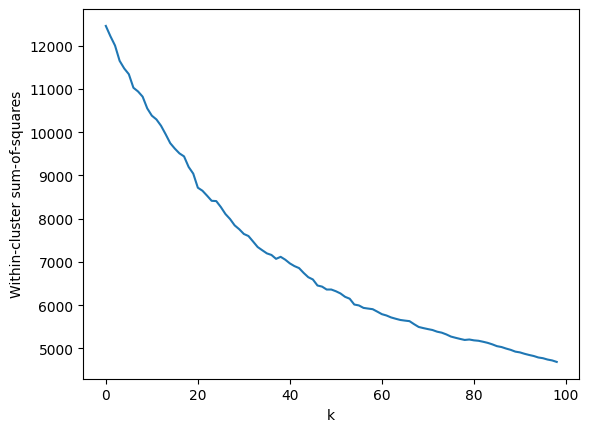

In [36]:
plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

## Visualisation

In [40]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.07648849, 0.03713288, 0.03844153, ..., 0.38154166, 0.0256224 ,
        0.06770787], shape=(12726,)),
 array([-0.02558798,  0.02521105,  0.03020719, ...,  0.80861502,
         0.01917745, -0.02120896], shape=(12726,)),
 array([ 0.02677062,  0.03530026,  0.03889705, ..., -0.11113867,
         0.21129105,  0.02764106], shape=(12726,))]

To see if we can see structure, we plot datas with colours determined by the category it comes from :

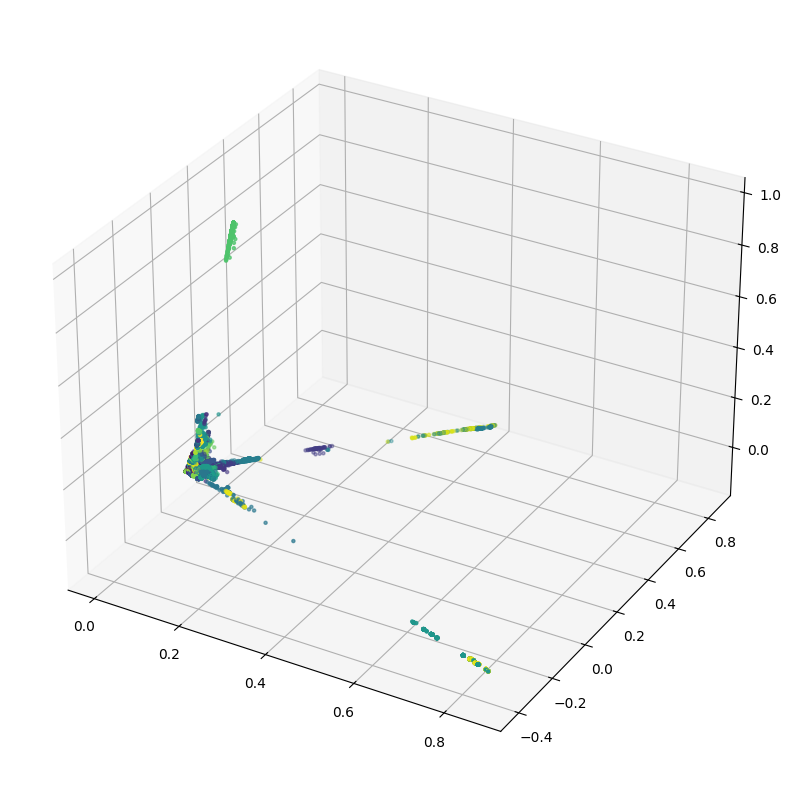

In [46]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(labels), marker='.');

Some clusters can be seen at the extremities, but in the centre it is difficult to see the different clusters.

We can plot the same data coloured according to the clusters found by the k-Means algorithm:

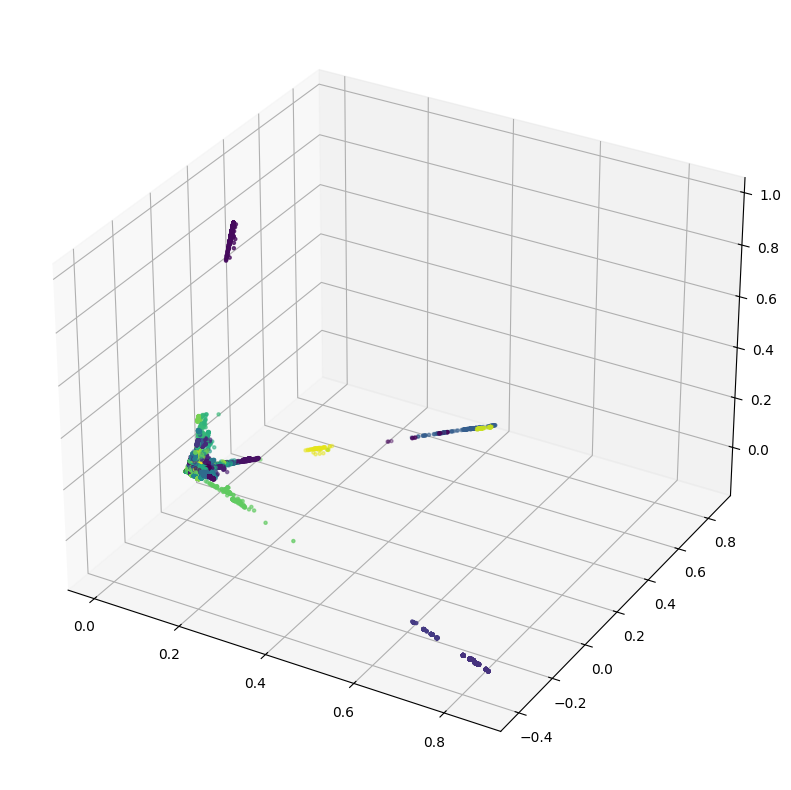

In [ ]:


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.');

## Topic model
Let's now see a different type of clustering called *topic modeling*

Here, in topic modelling each document belongs to many clusters at the same time unlike with k-means clustering.

We will use an algorithm called Latent Dirichlet Allocation (LDA). The LDA algorithm will learn a low dimensional representation of the documents.

In [47]:
from sklearn.model_selection import train_test_split

documents_train = [f"{sample['question']}\n\n{sample.get('hint', '')}\n\n{sample.get('lecture', '')}\n\n{sample.get('solution', '')}" 
             for sample in dataset['train']]

documents_test = [f"{sample['question']}\n\n{sample.get('hint', '')}\n\n{sample.get('lecture', '')}\n\n{sample.get('solution', '')}" 
             for sample in dataset['test']]

print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

No. training docs: 12726
No. testing docs: 4241


In [48]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(documents_train)

In [49]:
vocab = vectorizer.get_feature_names_out()
len(vocab)

5911

Note: we have the same *len(vocab)*, it was expected

### Extracting topics using Latent Dirichlet Allocation (LDA)
Now we'll fit an LDA topic model to the dataset.

Just like with k-Means where we needed to choose the number of clusters with topic models we need to choose the number of topics to use to represent each document.
We chose the number of topic equal to 50 ( ~10% of vocab size )

In [69]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=50, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=50, verbose=1)

The model is now trained, we can measure the performance of the model with its perplexity. Perplexity measues how confused/surprise a model is at seeing new data.

In [70]:
vector_documents_test = vectorizer.transform(documents_test)
lda.perplexity(vector_documents_test)

np.float64(191.05403330739514)

Let's now have a look at the topics found:

In [71]:
import numpy as np

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [coat, black, pattern, boundary, curly, ll, guards, ridge, aa, age]
Topic 2:	 [experiment, plants, soil, different, answer, measured, identify, tested, questions, daffodil]
Topic 3:	 [sentence, clause, weather, independent, compound, simple, dependent, place, certain, atmosphere]
Topic 4:	 [words, letters, page, order, word, guide, alphabetical, comes, look, second]
Topic 5:	 [particles, higher, sample, average, kinetic, energy, substance, particle, temperature, speed]
Topic 6:	 [choice, average, incorrect, precipitation, writer, does, months, month, graph, use]
Topic 7:	 [test, bridge, design, moved, time, high, distance, moving, process, speed]
Topic 8:	 [number, unit, units, long, estimate, written, shows, length, means, better]
Topic 9:	 [body, backbone, fossil, like, animal, vertebrate, invertebrates, does, fossils, insects]
Topic 10:	 [plant, seeds, grow, new, plants, eggs, female, fruit, pollen, egg]
Topic 11:	 [tense, verbs, past, tell, present, beak, future, regular,

The results seems to be coherent when looking at the different words present in a topic.

Now, let's visualize the prevalence of the words in each topic :

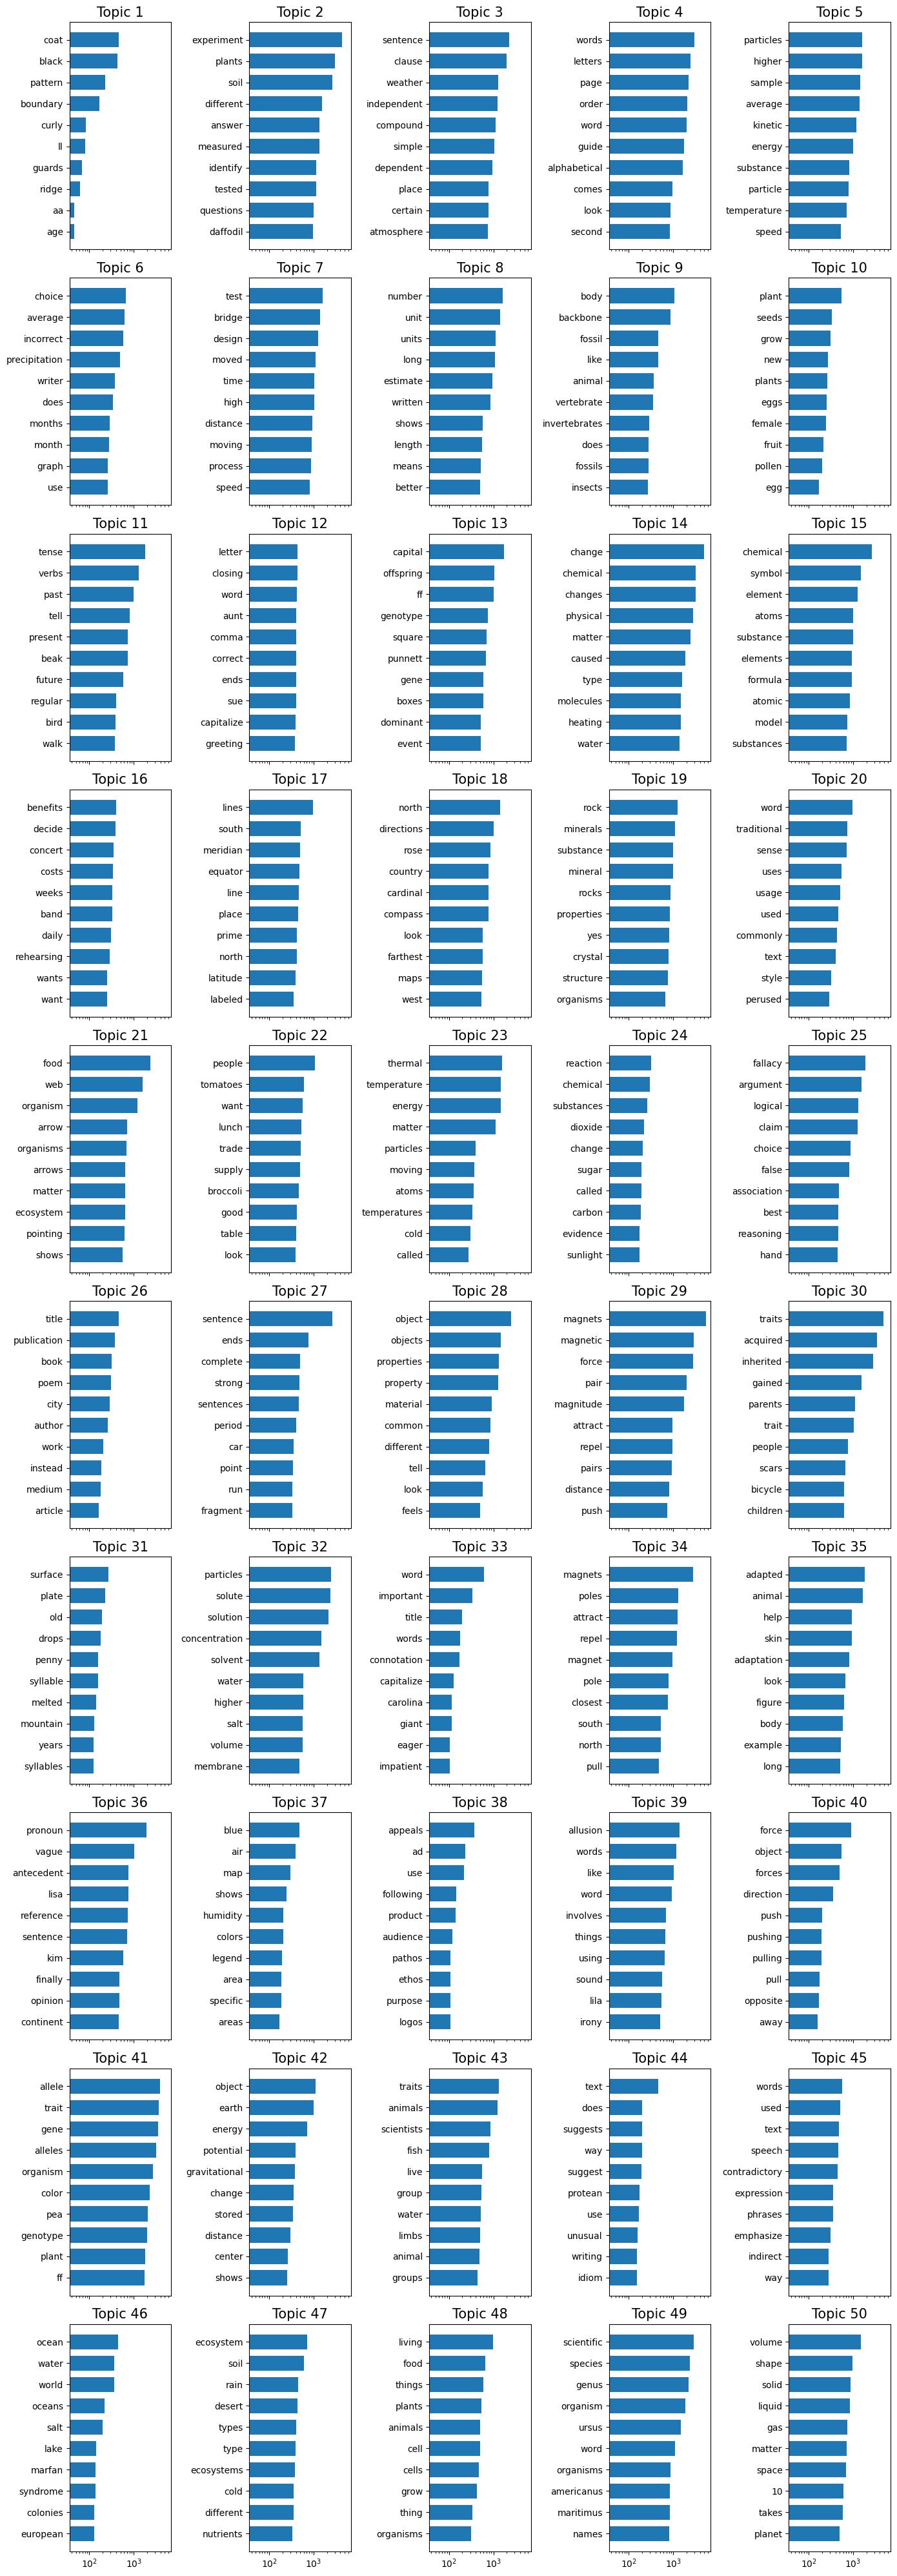

In [72]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

### Investigating the topic description for a single document
In topic modeling each document is represented by a vector of topics, rather than a single cluster. Thus, we can describe a document content.
Let's see a document that LDA model did not see during training.

In [108]:
doc = documents_test[7]

print(doc)

Which figure of speech is used in this text?
The salesperson tried hard to convince Franklin that the jacket was a good buy; after all, it was made of genuine imitation leather.



Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.
Anaphora is the repetition of the same word or words at the beginning of several phrases or clauses.
We are united. We are powerful. We are winners.
Antithesis involves contrasting opposing ideas within a parallel grammatical structure.
I want to help, not to hurt.
Apostrophe is a direct address to an absent person or a nonhuman entity.
Oh, little bird, what makes you sing so beautifully?
Assonance is the repetition of a vowel sound in a series of nearby words.
Try to light the fire.
Chiasmus is an expression in which the second half parallels the first but reverses the order of words.
Never let a fool kiss you or a kiss fool you.
A euphemism is a polite or indirect expression that 

Now to see its topic vector we need to vectorize and then transform (using LDA) the document to the topic space:

In [109]:
doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]
topic_vec

array([1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 3.51035659e-02,
       8.40930185e-03, 5.40233606e-03, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 7.25992676e-03, 1.34228188e-04, 2.51923450e-02,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       7.69041487e-03, 8.06190425e-03, 6.00235626e-02, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04, 1.34228188e-04, 8.31984746e-03,
       8.29167668e-01, 1.34228188e-04, 1.34228188e-04, 1.34228188e-04,
       1.34228188e-04, 1.34228188e-04])

We now have the topic vector representation of the document above.

Note : many topics have a small value associated with them, this just means that no words from that topic were found in the document.

Now, let's sort the topics from the most important to least, and print the top 10 topics ( removing those with frequency less than 1%):

In [110]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

In [111]:
for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

82.9% Topic 44: words used text speech contradictory expression phrases emphasize indirect way
6.0% Topic 38: allusion words like word involves things using sound lila irony
3.5% Topic 19: word traditional sense uses usage used commonly text style perused
2.5% Topic 27: object objects properties property material common different tell look feels


This seems to be a good description of the selectede document, the text was talking about figures of speech so the topic 44 seems particulary relevent, as well as the other topics shown.

### Visualising Topic Representations of Documents with t-SNE


This time, we will dimentionality reduction technique called t-SNE

In [112]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

(4241, 3)

In [113]:
[x, y, z] = np.transpose(tsne_embedding)

Here is the 3D plot assigning each document to its most frequent topic and colour based on the topic:

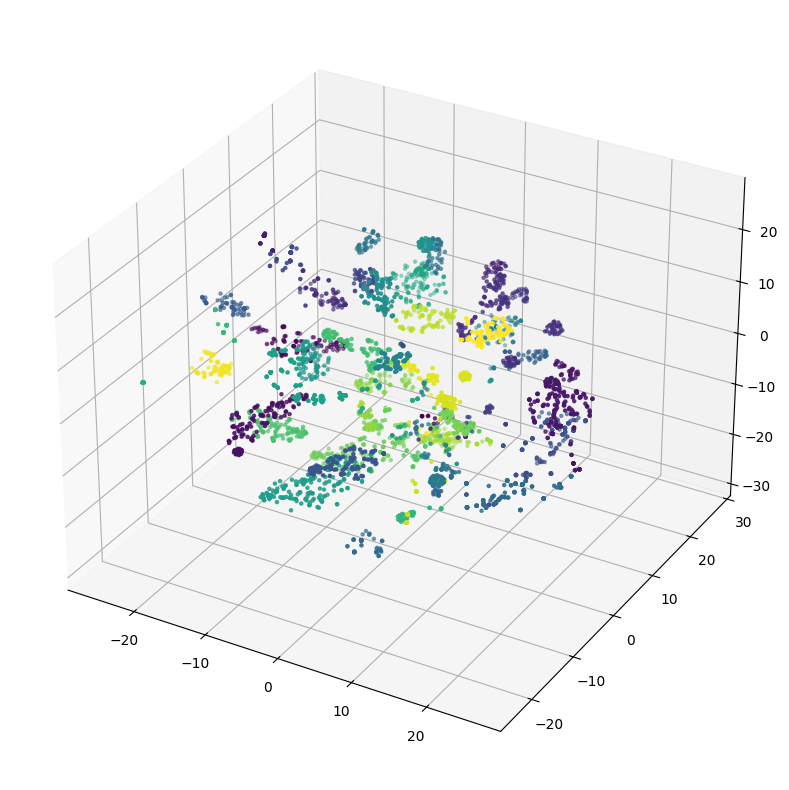

In [80]:
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=freq_topic, marker='.');

Here is the same graph plot using plotly instead so we can have an interactive plot :

In [81]:
import plotly.express as px
import pandas as pd

# On rassemble les données dans un DataFrame
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z,
    'topic': freq_topic
})

# Graphe interactif 3D avec couleurs par topic
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='topic',  # couleur selon topic dominant
                    opacity=0.7,
                    title="Clustering LDA en 3D (interactive)")

fig.update_traces(marker=dict(size=3))  # point plus petit
fig.show()
